<a href="https://colab.research.google.com/github/yuriarciniegas/yoaprendo1/blob/master/CineColombianoScatterText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scattertext (https://github.com/JasonKessler/scattertext), awsome library for text visualization.**

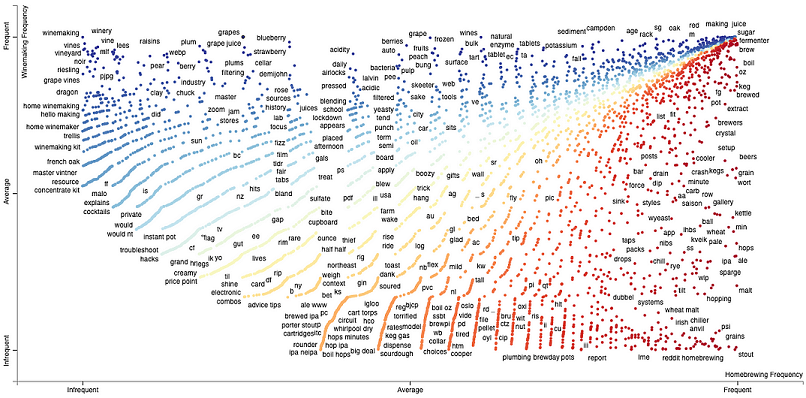

**Step 1. Install scattertext**

In [ ]:
!pip install scattertext

import warnings
warnings.filterwarnings("ignore")

**Step 2. Load text dataset**

In [ ]:
import pandas as pd

#Read data from Google Sheet: experimentos.analitica.datos - EncuestaCineColombiano_Respuestas
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQC3CXrmRk6mpK9-DrpO--faGVT_KsR8rj-AToUfFlsbKNnUB2wVslmNYiFT1pv80Z5gp76tgSqp1aN/pub?gid=1802142849&single=true&output=tsv", sep="\t")

df.columns = ['A','B','C','D','E']

#df.shape
df.head()


**Step 3. Transform dataset**

In [ ]:
good_df = df[['C']]
good_df['Opinion'] = "POSITIVE"

bad_df = df[['D']]
bad_df.columns = ['C']
bad_df['Opinion'] = "NEGATIVE"

df_op = pd.concat([good_df,bad_df])
df_op.columns = ['Opinion','Type']

df_op.groupby(['Type']).count()

**Step 4. Text preprocessing function**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
import unicodedata

nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words = stop_words.union(set(['pelicula', 'peliculas', 'colombiana', 'colombiano', 'colombia', 'colombianas', 'producciones', 'cine', 'me', 'le', 'da', 'mi', 'su', 'ha', 'he', 'ya', 'un', 'una', 'es','del', 'las', 'los', 'en', 'que', 'y', 'la','de']))

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def fast_preproc(text):
  text = text.lower()
  text = ''.join(c for c in text if not c.isdigit())
  text = ''.join(c for c in text if c not in punctuation)
  text = remove_accents(text)
  words = word_tokenize(text)
  #words = [stemmer.stem(word) for word in words]
  words = [word for word in words if not word in stop_words]
  try:
    text = " ".join(str(word) for word in words)
  except Exception as e:
    print(e)
    pass
  return text

print(fast_preproc("áéíóú ÁÉÍÓÚ FRAN Romero; Análisis de Textos. 2022"))

**Step 5. Applying text preprocessing function**

In [ ]:
df_op['Opinion'] = df_op['Opinion'].astype(str)

df_op = df_op.assign(
    preproc=lambda df: df.Opinion.apply(fast_preproc)
)

df_op.head()

**Step 6. Applying scattertext transformation**

In [ ]:
import scattertext as st

df_def = df_op.assign(
    parse=lambda df: df.preproc.apply(st.whitespace_nlp_with_sentences)
)

df_def.head()

**Step 7. Create a scatter with the opinions**

Positive vs. Negative vs. Frequency

In [ ]:
corpus = st.CorpusFromParsedDocuments(
    df_def, category_col='Type', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

html = st.produce_scattertext_explorer(
    corpus,
    category='POSITIVE', category_name='POSITIVE', not_category_name='NEGATIVE',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000, metadata=corpus.get_df()['Type'],
    transform=st.Scalers.dense_rank
)
open('./negative_vs_positive.html', 'w').write(html)

**Step 8. Crate a scatter with words relations**

In [ ]:
html = st.produce_scattertext_explorer(corpus,
                                       category='POSITIVE',
                                       category_name='POSITIVE',
                                       not_category_name='NEGATIVE',
                                       width_in_pixels=1000,
                                       metadata=df_def['Type'])

open("words_relations.html", 'wb').write(html.encode('utf-8'))

**Step 9. Words by Opinion**

In [ ]:
import scattertext as st

corpus = (st.CorpusFromPandas(df_op,
                              category_col='Type',
                              text_col='preproc',
                              nlp=st.whitespace_nlp_with_sentences)
          .build()
          .get_unigram_corpus()
          .compact(st.ClassPercentageCompactor(term_count=2,
                                               term_ranker=st.OncePerDocFrequencyRanker)))
html = st.produce_characteristic_explorer(
	corpus,
	category='POSITIVE',
	category_name='POSITIVE',
	not_category_name='NEGATIVE',
	metadata=corpus.get_df()['Type']
)
open('words_by_opinion.html', 'wb').write(html.encode('utf-8'))